# EDA (exploratory data analysis) of autos dataset

371528 cars collected from german eBay until 2016

The content of the data is in german, so one has to translate it first if one can not speak german. Those fields are included:

- dateCrawled : when this ad was first crawled, all field-values are taken from this date
- name : "name" of the car
- seller : private or dealer
- offerType
- price : the price on the ad to sell the car
- abtest
- vehicleType
- yearOfRegistration : at which year the car was first registered
- gearbox
- powerPS : power of the car in PS
- model
- kilometer : how many kilometers the car has driven
- monthOfRegistration : at which month the car was first registered
- fuelType
- brand
- notRepairedDamage : if the car has a damage which is not repaired yet
- dateCreated : the date for which the ad at ebay was created
- nrOfPictures : number of pictures in the ad
- postalCode
- lastSeen : when the crawler saw this ad last online

**Importations**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

**Données**

In [2]:
df = pd.read_csv('autos.csv',encoding="latin-1")
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

# Data Cleaning

In [4]:
# Colonnes à supprimer (ne seront pas utilisées par la suite)
to_drop = ['abtest', 'dateCreated', 'postalCode']
df.drop(to_drop, inplace = True, axis = 1)

- seller

In [5]:
# Valeurs uniques
df['seller'].unique()

array(['privat', 'gewerblich'], dtype=object)

In [6]:
# On remplace les mots en allemand par leurs équivalents anglais
df['seller'] = df['seller'].map({'privat':'private','gewerblich' : 'commercial'})

- offerType

In [7]:
# Valeurs uniques
df["offerType"].unique()

array(['Angebot', 'Gesuch'], dtype=object)

In [8]:
# On remplace les mots en allemand par leurs équivalents anglais
df["offerType"] = df["offerType"].map({'Gesuch':"Request",'Angebot':'Offer'})

- yearOfRegistration

<Figure size 504x504 with 0 Axes>

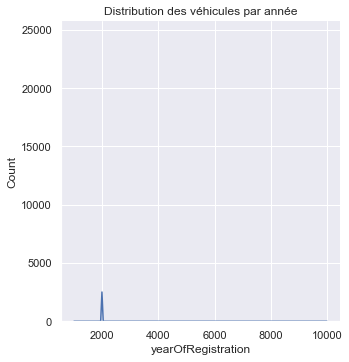

In [9]:
# Distribution des véhicules selon 'yearOfRegistration'
plt.figure(figsize=(7,7))
sns.displot(df["yearOfRegistration"], kde = True)
plt.title('Distribution des véhicules par année')
plt.show();


In [10]:
df["yearOfRegistration"].min()

1000

Il semble qu'il y ait des outliers : les années dépassent nettement 2020 et commencent en l'an 1000 !

In [11]:
# On supprime les lignes contenant les outliers pour yearOfRegistration
df = df[(df["yearOfRegistration"] >= 1938) & (df["yearOfRegistration"] <= 2020)]

- vehicleType

In [12]:
# Valeurs manquantes
df["vehicleType"].isna().sum()

37611

In [13]:
# On remplace les NaN de 'vehicleType' par 'Other'
df["vehicleType"].fillna("Other", inplace=True)

- price

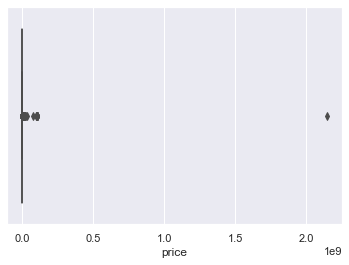

In [14]:
# Boxplot pour détecter les outliers
sns.boxplot(df['price']);

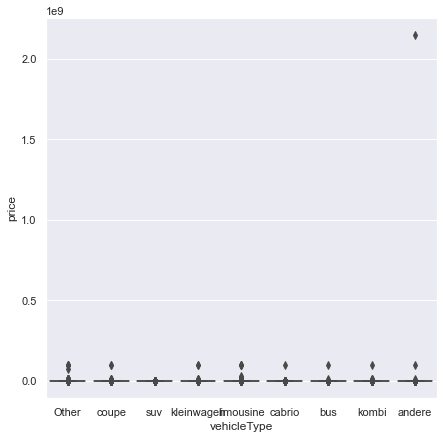

In [15]:
# Boxplot des prix par type de véhicule
plt.figure(figsize=(7,7))
sns.boxplot(x="vehicleType", y="price", data=df)
plt.show();

Il semble qu'il y ait des outliers (surtout pour le type 'andere').

On va utliser l'approche IQR (Inter Quartile Range) pour supprimer les valeurs aberrantes (pour tous les types de véhicules).

In [16]:
# 3ème quartile des prix par type de véhicule
Q3 = df.groupby("vehicleType")["price"].quantile(0.75)

# 1er quartile des prix par type de véhicule
Q1 = df.groupby("vehicleType")["price"].quantile(0.25)

# Définition de la valeur de base aberrante par limite supérieure :
iqr = (Q3 - Q1)*1.5 + Q3
iqr

vehicleType
Other          6900.000
andere        11125.000
bus           17947.500
cabrio        28000.000
coupe         33650.000
kleinwagen     7875.000
kombi         17576.500
limousine     17401.500
suv           35711.875
Name: price, dtype: float64

In [17]:
# On supprime les outliers selon la méthode ci-dessus :
df = df[((df["vehicleType"] == "andere") & (df["price"] <= 11125)) |
        ((df["vehicleType"] == "Other") & (df["price"] <= 5250)) |
        ((df["vehicleType"] == "suv") & (df["price"] <= 35723.75)) |
        ((df["vehicleType"] == "kombi") & (df["price"] <= 17576.5)) |
        ((df["vehicleType"] == "bus") & (df["price"] <= 17947.5)) |
        ((df["vehicleType"] == "cabrio") & (df["price"] <= 28000)) |
        ((df["vehicleType"] == "limousine") & (df["price"] <= 17401.1)) |
        ((df["vehicleType"] == "coupe") & (df["price"] <= 33650)) |
        ((df["vehicleType"] == "kleinwagen") & (df["price"] <= 7875))]

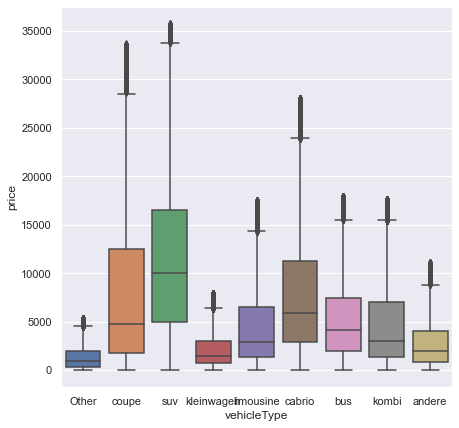

In [18]:
# Boxplot des prix par type de véhicule (sans les outliers)
plt.figure(figsize=(7,7))
sns.boxplot(x="vehicleType", y="price", data=df)
plt.show();

- gearbox

In [19]:
# Valeurs manquantes
df["gearbox"].isna().sum()

18845

In [20]:
# On remplace les NaN de 'gearbox' par 'Unspecified'
df["gearbox"].fillna("Unspecified", inplace=True)

- fuelType

In [21]:
# Valeurs manquantes
df["fuelType"].isna().sum()

30677

In [22]:
# On remplace les Nan de 'fuelType' par 'Unspecified'
df["fuelType"].fillna("Unspecified",inplace=True)

In [23]:
# Différents types de carburant
df["fuelType"].unique()

array(['benzin', 'diesel', 'Unspecified', 'lpg', 'andere', 'hybrid',
       'cng', 'elektro'], dtype=object)

In [24]:
# On remplace les mots en allemand par leurs équivalents anglais
df["fuelType"] = df["fuelType"].map({'benzin':'Gasoline','diesel':'Diesel', 'lpg':'Lpg','hybrid':'Hybrid',
                                     'cng':'Cng','elektro':'Electric'})

- nrOfPictures

In [25]:
# Valeurs uniques
df["nrOfPictures"].unique()

array([0], dtype=int64)

In [26]:
# On supprime cette colone qui ne contient que des zéros
df.drop(df["nrOfPictures"], inplace = True)

- notRepairedDamage

In [27]:
# Valeurs manquantes
df["notRepairedDamage"].isna().sum()

68498

In [28]:
# On remplace les Nan par 'Other'
df["notRepairedDamage"].fillna("Other",inplace=True)

In [29]:
# Valeurs uniques
df["notRepairedDamage"].unique()

array(['ja', 'Other', 'nein'], dtype=object)

In [30]:
# On remplace les mots en allemand par leur équivalent anglais
df["notRepairedDamage"] = df["notRepairedDamage"].map({'ja':'Yes','nein':'No'})

- model

In [31]:
# Valeurs manquantes
df["model"].isna().sum()

18829

In [32]:
# On remplace les Nan par 'Other'
df["model"].fillna("Other",inplace=True)

- dateCrawled et lastSeen

In [33]:
# Calcul du nombre de jours où l'annonce est restée en ligne
start_date = df['dateCrawled'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
stop_date = df['lastSeen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
days = abs((start_date - stop_date))
days = (days / np.timedelta64(1, 'D')).astype(int)
df["timeOnline"] = days

# Data Visualization

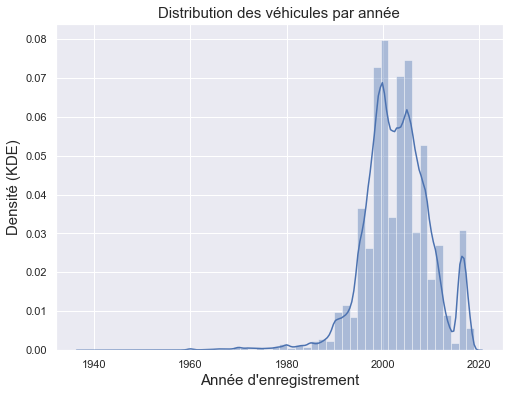

In [34]:
# Distribution des véhicules par année
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df["yearOfRegistration"], kde = True, ax = ax)
plt.title('Distribution des véhicules par année', fontsize = 15)
plt.ylabel("Densité (KDE)", fontsize = 15)
plt.xlabel("Année d'enregistrement", fontsize = 15)
plt.show();

**Types et marques de véhicules**

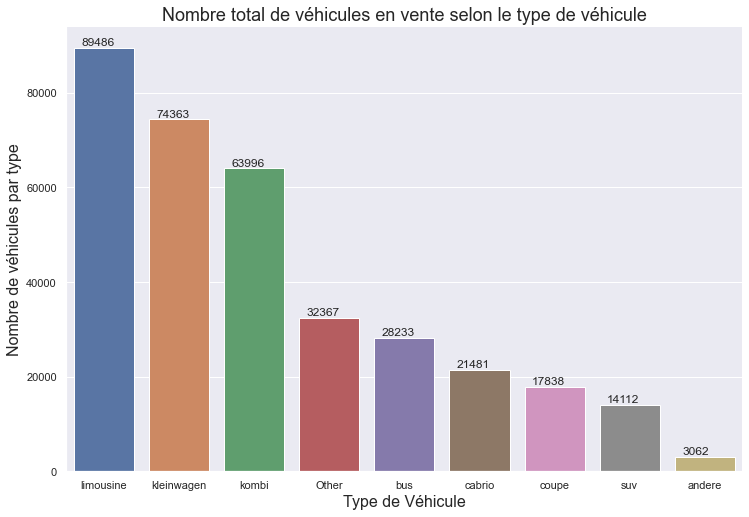

In [35]:
# Diagramme en barres du nombre de véhicules de chaque type
g = sns.catplot(x = "vehicleType", data = df, kind ="count", size = 7, aspect = 1.5, 
                order = df['vehicleType'].value_counts().index)
g.ax.set_title("Nombre total de véhicules en vente selon le type de véhicule", fontdict= {'size':18})
g.ax.xaxis.set_label_text("Type de Véhicule", fontdict= {'size':16})
g.ax.yaxis.set_label_text("Nombre de véhicules par type", fontdict= {'size':16})


# Pour avoir le total au sommet de chaque barre
for p in g.ax.patches:
    g.ax.annotate((p.get_height()), (p.get_x()+0.1, p.get_height()+500))

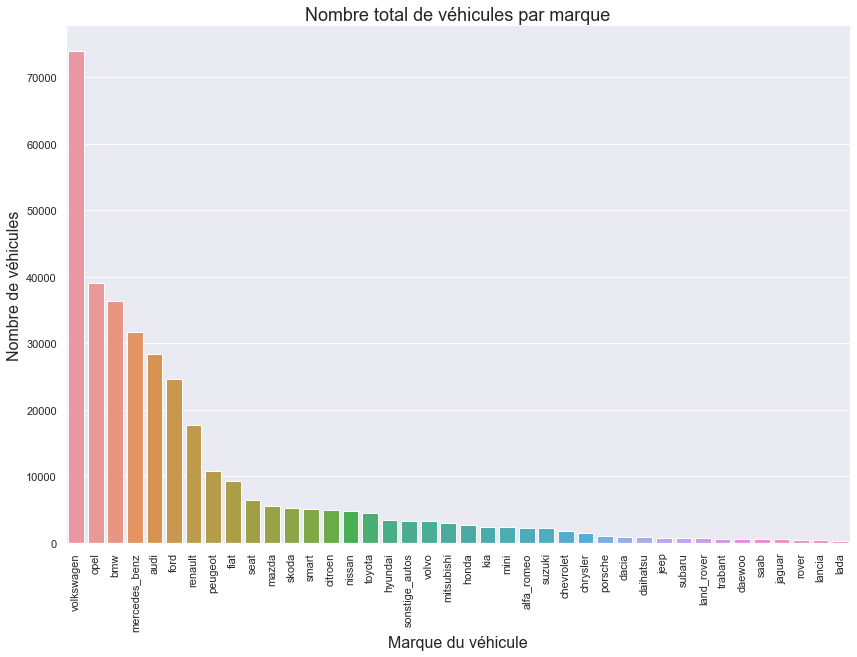

In [36]:
# Nombre total de véhicules par marque (brand)
g = sns.catplot(x = "brand", data = df, kind = "count", size = 8, aspect = 1.5, order = df['brand'].value_counts().index)
g.ax.set_title("Nombre total de véhicules par marque", fontdict = {'size':18})
g.ax.xaxis.set_label_text("Marque du véhicule", fontdict = {'size':16})
g.ax.yaxis.set_label_text("Nombre de véhicules", fontdict = {'size':16})
g.set_xticklabels(rotation = 90);

**Prix**

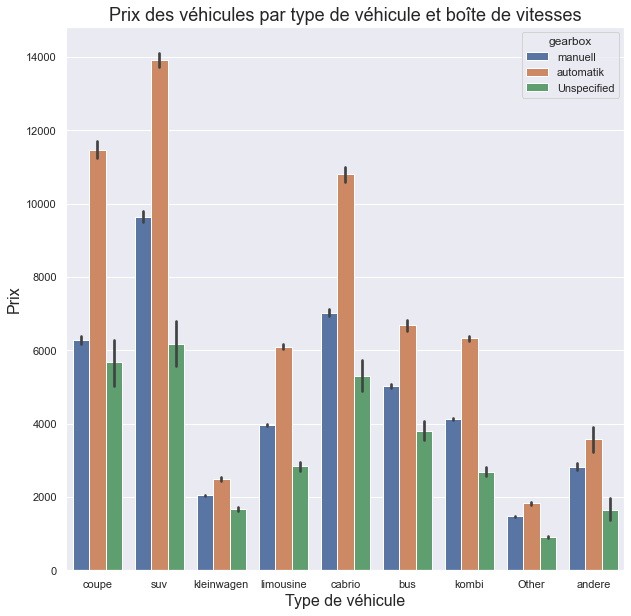

In [37]:
# Prix des véhicules par type de véhicule et boîte de vitesses
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = "vehicleType", y = "price", hue = "gearbox", data = df)
ax.set_title("Prix des véhicules par type de véhicule et boîte de vitesses", fontdict = {'size':18})
ax.xaxis.set_label_text("Type de véhicule", fontdict = {'size':16})
ax.yaxis.set_label_text("Prix", fontdict= {'size':16})
plt.show()

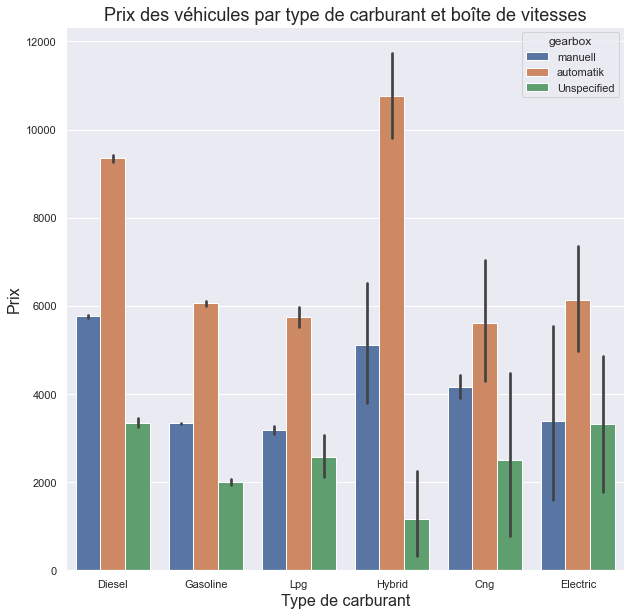

In [38]:
# Prix des véhicules par type de carburant et boîte de vitesses
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = "fuelType", y = "price", hue = "gearbox", data = df)
ax.set_title("Prix des véhicules par type de carburant et boîte de vitesses", fontdict = {'size':18})
ax.xaxis.set_label_text("Type de carburant", fontdict = {'size':16})
ax.yaxis.set_label_text("Prix", fontdict= {'size':16})
plt.show()

**Puissance**

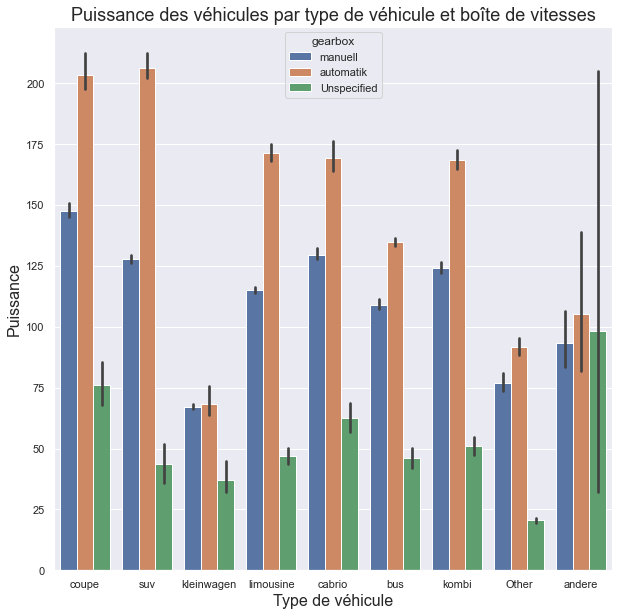

In [39]:
# Puissance des véhicules par type de véhicule et boîte de vitesses
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x = "vehicleType", y = "powerPS", hue = "gearbox", data = df)
ax.set_title("Puissance des véhicules par type de véhicule et boîte de vitesses", fontdict = {'size':18})
ax.xaxis.set_label_text("Type de véhicule", fontdict = {'size':16})
ax.yaxis.set_label_text("Puissance", fontdict= {'size':16})
plt.show()

**Nombre de jours en ligne**

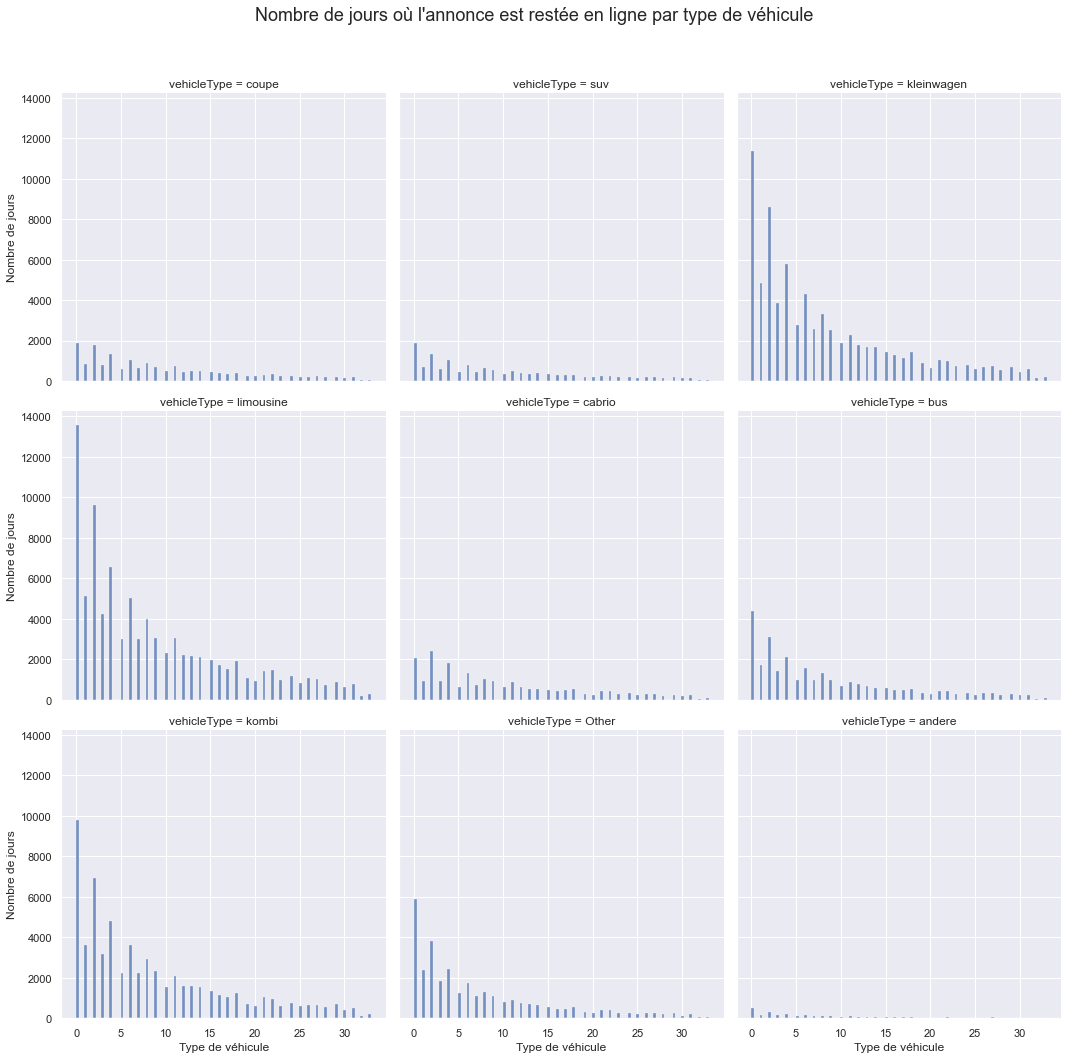

In [40]:
# Nombre de jours où l'annonce est restée en ligne par type de véhicule
g = sns.displot(x = "timeOnline", col = 'vehicleType', data = df, col_wrap = 3)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Nombre de jours où l'annonce est restée en ligne par type de véhicule", size = 18)
g.set(xlabel = 'Type de véhicule', ylabel = 'Nombre de jours');